In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
# The data describe the problem of high energy (higher than 10^4 J) 
# seismic bumps forecasting in a coal mine. 
# Data come from two of longwalls located in a Polish coal mine.
dataset = pd.read_csv('seismic-bumps.csv')
dataset

,V1,V2,V3,V4,V5,V6,V7,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [3]:
dataset = dataset.sample(frac = 1) 

X = dataset[dataset.columns.difference(['Class'])]
y = pd.DataFrame(dataset['Class'])

In [4]:
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,Class
188,11.23,12.82,0.8594,5.089,2.821,7.524,4.957,3
127,17.98,15.85,0.8993,5.979,3.687,2.257,5.919,2
191,11.27,12.86,0.8563,5.091,2.804,3.985,5.001,3
51,15.78,14.91,0.8923,5.674,3.434,5.593,5.136,1
66,14.34,14.37,0.8726,5.630,3.190,1.313,5.150,1


In [5]:
X.head()

,V1,V2,V3,V4,V5,V6,V7
188,11.23,12.82,0.8594,5.089,2.821,7.524,4.957
127,17.98,15.85,0.8993,5.979,3.687,2.257,5.919
191,11.27,12.86,0.8563,5.091,2.804,3.985,5.001
51,15.78,14.91,0.8923,5.674,3.434,5.593,5.136
66,14.34,14.37,0.8726,5.630,3.190,1.313,5.150


In [6]:
y.head()

,Class
188,3
127,2
191,3
51,1
66,1


In [7]:
X_list = X.values.tolist()
y_list = list(itertools.chain.from_iterable(y.values.tolist()))

In [8]:
X_list[0:5]

[[11.23, 12.82, 0.8594, 5.0889999999999995, 2.821, 7.524, 4.957],
 [17.98, 15.85, 0.8993, 5.979, 3.687, 2.2569999999999997, 5.919],
 [11.27, 12.86, 0.8563, 5.091, 2.804, 3.985, 5.001],
 [15.78, 14.91, 0.8923, 5.6739999999999995, 3.4339999999999997, 5.593, 5.136],
 [14.34, 14.37, 0.8726, 5.63, 3.19, 1.3130000000000002, 5.15]]

In [9]:
y_list[0:5]

[3, 2, 3, 1, 1]

In [10]:
CLASSES_NUM = 3

In [11]:
def sum_mean_vectors(vectors):
    L = len(vectors)
    M = len(vectors[0])
    
    assert(L != 0)
    assert(M != 0)
    
    res_vector = [0] * M
    
    for vec in vectors:
        assert(len(vec) == M)
        for i in range(M):
            res_vector[i] += vec[i]
    
    for i in range(M):
        res_vector[i] = res_vector[i] / L
    return res_vector
        
    
def euclidean_distance(x, y):
    assert(len(x) == len(y))
    distance = 0
    
    for i in range(len(x)):
        distance += (x[i] - y[i]) ** 2
    distance = math.sqrt(distance)
    
    return distance
        

# Ward's distance, take two clusters as arguments
def wards_distance(w, s):
    coef = len(s) * len(w) / (len(s) + len(w))
    s_vector = sum_mean_vectors(s)
    w_vector = sum_mean_vectors(w)
    dist = euclidean_distance(w_vector, s_vector)
    dist_square = dist ** 2
    return coef * dist_square
    

In [12]:
def find_two_closest(clusters, X):
    min_i = -1
    min_j = -1
    min_dist = 1e40
    
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            s = []
            w = []
            for idx in cluster1:
                s.append(X[idx])
            for idx in cluster2:
                w.append(X[idx])
            dist = wards_distance(w, s)
            if dist < min_dist:
                min_dist = dist
                min_i = i
                min_j = j
    return min_i, min_j
            
            
def lance_williams_algorithm(X, k):
    l = len(X)
    clusters_init = [[i] for i in range(l)]
    clusters_sets = []
    clusters_sets.append(clusters_init)
    for t in tqdm(range(1, l)):
        fst_index, snd_index = find_two_closest(clusters_sets[t - 1], X)
        assert(fst_index != -1)
        assert(snd_index != -1)
        clusters = []
        for i, clust in enumerate(clusters_sets[t - 1]):
            if i != fst_index and i != snd_index:
                clusters.append(clust.copy())
        clust1 = clusters_sets[t - 1][fst_index]
        clust2 = clusters_sets[t - 1][snd_index]
        union_clust = clust1.copy() + clust2.copy()
        clusters.append(union_clust)
        clusters_sets.append(clusters)
        
        if len(clusters) == k:
            return clusters
    
    return clusters_sets[-1]

In [13]:
def vector_diff(x, y):
    assert(len(x) == len(y))
    res = []
    for i in range(len(x)):
        res.append(x[i] - y[i])
    return res

def vector_norm(vec):
    return euclidean_distance(vec, [0] * len(vec))

def inter_cluster_distance(cluster1, cluster2):
    min_norm = 1e40
    for vec_1 in cluster1:
        for vec_2 in cluster2:
            diff = vector_diff(vec_1, vec_2)
            norm = vector_norm(diff)
            if norm < min_norm:
                min_norm = norm
    return min_norm

def cluster_diameter(cluster):
    max_norm = 0
    for vec_1 in cluster:
        for vec_2 in cluster:
            diff = vector_diff(vec_1, vec_2)
            norm = vector_norm(diff)
            if norm > max_norm:
                max_norm = norm
    return max_norm


def dunn_index(X, clusters):
    min_up = 1e40
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster_objs_1 = [X[k] for k in clusters[i]]
            cluster_objs_2 = [X[k] for k in clusters[j]]
            dist = inter_cluster_distance(cluster_objs_1, cluster_objs_2)
            if dist < min_up:
                min_up = dist
    max_down = 0
    for cluster in clusters:
        cluster_objs = [X[k] for k in cluster]
        dim = cluster_diameter(cluster_objs)
        if dim > max_down:
            max_down = dim

    return min_up / max_down

In [14]:
def f_score(labels, clusters):
    n = np.array([[0] * len(clusters) for _ in range(len(labels))])
    for j in range(len(clusters)):
        for i in clusters[j]:
            n[labels[i]][j] += 1
    
    p = n / np.sum(n)
    
    result = 0
    for j in range(len(clusters)):
        row_sum = np.sum(p, axis=1)
        col_sum = np.sum(p, axis=0)
        if np.isclose(col_sum[j], 0):
            continue
        result += col_sum[j] * np.max([(2 * p[i][j] ** 2 / (row_sum[i] * col_sum[j])) 
                                       / (p[i][j] / row_sum[i] + p[i][j] / col_sum[j]) 
                                       for i in range(len(labels)) 
                                       if not np.isclose(row_sum[i], 0) and not np.isclose(p[i][j], 0)])
        
    return result

In [15]:
def label_to_color(label):
    if label == 1:
        return 'y'
    elif label == 2:
        return 'b'
    elif label == 3:
        return 'g'
    else:
        return 'k'

In [16]:
def draw_clusters(X, clusters):
    for i, cluster in enumerate(clusters):
        X_from_cluster = [X[i] for i in cluster]
        col = label_to_color(i + 1)
        plt.scatter([x[0] for x in X_from_cluster], [x[1] for x in X_from_cluster],s=10, color=col)
    plt.title("Result clusters")
    plt.show()

In [17]:
def draw_real_classes(X, y):
    assert(len(X) == len(y))
    for i in range(len(X)):
        col = label_to_color(y[i])
        plt.scatter([X[i][0]],[X[i][1]], color=col,s=10)
    plt.title("Real classes")
    plt.show()

In [18]:
clusters = lance_williams_algorithm(X_list, 3)

 99%|█████████▊| 206/209 [00:16<00:00, 12.15it/s]


In [19]:
pca = PCA(n_components=2)
transformed_X = pca.fit_transform(X).tolist()


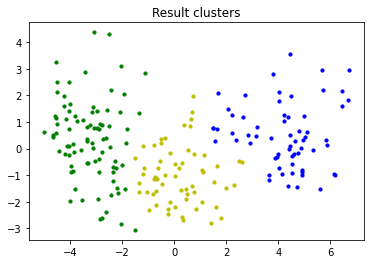

In [20]:
draw_clusters(transformed_X, clusters)

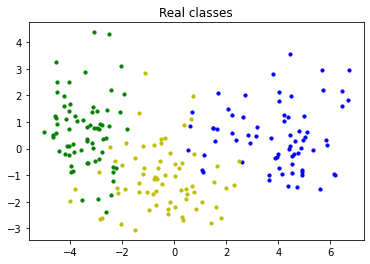

In [21]:
draw_real_classes(transformed_X, y_list)

In [ ]:
f_scores = []
dunn_indexes = []
ks = list(range(2, 7))
for k in ks:
    clusters = lance_williams_algorithm(X_list, k)
    dunn = dunn_index(X_list, clusters)
    fscore = f_score(y_list, clusters)
    dunn_indexes.append(dunn)
    f_scores.append(fscore)    

 43%|████▎     | 89/209 [00:12<00:11, 10.39it/s]

In [ ]:
plt.plot(ks, f_scores)
plt.xlabel('Clusters count')
plt.ylabel('F-score')
plt.show()

In [ ]:
plt.plot(ks, dunn_indexes)
plt.xlabel('Clusters count')
plt.ylabel('Dunn Index')
plt.show()